In [ ]:
!pip install spotipy --upgrade

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pprint

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
cid = "7c93e63264394119b9654a758a2eacce"
secret = ""

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

#korean hits
#spotify:playlist:37i9dQZF1DWT9uTRZAYj0c
#playlist_URI="37i9dQZF1DWT9uTRZAYj0c"
#Best of korean soundtracks
#playlist_URI="37i9dQZF1DWUXxc8Mc6MmJ"
#chill korean music
#playlist_URI="3P23kTfVXOzo4voDEZLyCk"

In [ ]:
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

In [ ]:
for track in sp.playlist_tracks(playlist_URI)["items"]:
  meta=sp.track(track["track"]["id"])
  features=sp.audio_features(track["track"]["id"])
  # meta
  name = meta['name']
  artist = meta['album']['artists'][0]['name']
  length = meta['duration_ms']
  ids =  meta['id']
  # features
  acousticness = features[0]['acousticness']
  danceability = features[0]['danceability']
  energy = features[0]['energy']
  instrumentalness = features[0]['instrumentalness']
  liveness = features[0]['liveness']
  valence = features[0]['valence']
  loudness = features[0]['loudness']
  speechiness = features[0]['speechiness']
  tempo = features[0]['tempo']
  key = features[0]['key']
  time_signature = features[0]['time_signature']
  music_list.append([ids, name, artist, length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo])

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/학교 프로젝트/2022 슈퍼챌린지 SW 해커톤/song_data/data_moods.csv")

In [ ]:
col_features = df.columns[6:-3]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

In [ ]:
X.shape

(686, 10)

In [ ]:
#Encodethe categories
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)


#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [ ]:
def base_model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(8,input_dim=10,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(4,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [ ]:
#Configure the model
estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


In [ ]:
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0,

Baseline: 79.15% (3.05%)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [ ]:
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


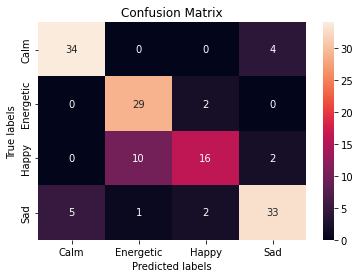

Accuracy Score 0.8115942028985508


In [ ]:
cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [ ]:
test_df=pd.DataFrame(music_list, columns=["id","name","artist","length",'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo'])
test_df=test_df.drop_duplicates(subset=["id"])
test_features=test_df.columns[3:]
X_test= MinMaxScaler().fit_transform(test_df[test_features])
X_test = np.array(X_test)

In [ ]:
X_test

array([[5.58203657e-01, 8.63849765e-01, 9.49052122e-02, ...,
        5.50249584e-01, 1.19642531e-01, 2.26757987e-01],
       [5.52389573e-01, 6.04068858e-01, 8.73348511e-01, ...,
        2.67803661e-01, 1.38610250e-02, 2.33684866e-01],
       [5.45232290e-01, 4.53834116e-01, 7.46697022e-01, ...,
        2.91181364e-01, 4.86959694e-02, 2.47357020e-01],
       ...,
       [3.98169771e-01, 8.40375587e-01, 4.00548205e-04, ...,
        7.96422629e-01, 1.27849717e-01, 4.99610850e-01],
       [5.86291645e-01, 5.28951487e-01, 1.86547347e-01, ...,
        3.54908486e-01, 1.58672260e-02, 6.42844171e-01],
       [4.42456668e-01, 5.93114241e-01, 5.66008594e-02, ...,
        3.07903494e-01, 3.64763815e-02, 2.14402459e-01]])

In [ ]:
result=pd.concat([test_df,pd.DataFrame(estimator.predict_proba(X_test))],axis=1)
result.rename(columns={0:"Calm",1:"Energetic",2:"Happy",3:"Sad"},inplace=True)


In [ ]:
result

,id,name,artist,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,Calm,Energetic,Happy,Sad
0,5NHX9nf376Qlt5fsU84SQb,Mannequin (Feat. Beenzino & SURAN),Primary,233376,0.800,0.09300,0.568,0.000000,0.2070,0.7670,-5.616,0.0893,83.935,0.002440,0.219098,0.630096,0.148367
1,0Ft9pLHK8GSYxBjDLXZBMd,Fall,Crush,231571,0.634,0.84900,0.402,0.000007,0.0678,0.2470,-9.011,0.0313,85.003,0.058391,0.009038,0.032968,0.899603
2,0AO2yQNGcH0ASHHU5lS4lT,양화대교 (Yanghwa Brdg),Zion.T,229349,0.538,0.72600,0.436,0.000000,0.1510,0.3700,-8.730,0.0504,87.111,0.051829,0.018295,0.059082,0.870794
3,26BiSp0ava6jOuosmFKe1i,스포일러 Spoiler,Epik High,277983,0.625,0.01570,0.685,0.000000,0.3200,0.0602,-6.553,0.1660,71.987,0.002047,0.533651,0.270429,0.193872
4,4dNUnQackdix2H4zTBqYLP,Bawling,Primary,243175,0.757,0.48900,0.624,0.008530,0.1020,0.4850,-7.529,0.2550,87.017,0.009100,0.201023,0.432821,0.357056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,7DF8lvLdV3htIbuTWpc7lR,Girl Of My Dreams (with SUGA of BTS),Juice WRLD,226149,0.603,0.19400,0.771,0.000000,0.1300,0.3320,-6.336,0.0627,139.988,0.004891,0.472376,0.334629,0.188103
197,259wZqRoiqkrRMosDDnnOX,MELODY,ASH ISLAND,181629,0.641,0.36000,0.705,0.000000,0.1100,0.5480,-4.327,0.0508,150.125,0.007819,0.286724,0.426532,0.278924
198,4gdiCHNbwugojBqr5Jt3pq,WA DA DA,Kep1er,183693,0.785,0.00122,0.907,0.000003,0.2130,0.6850,-2.657,0.0938,126.004,0.000243,0.508551,0.474932,0.016274
199,7MAibcTli4IisCtbHKrGMh,Leave The Door Open,Bruno Mars,242096,0.586,0.18200,0.616,0.000000,0.0927,0.7190,-7.964,0.0324,148.088,0.007964,0.313317,0.440692,0.238026


In [ ]:
def make_20_list(emotion):
  temp_data=result.loc[:,["name","artist"]]
  return temp_data[:20]

for emotion in ["Sad","Happy","Calm"]:
  make_20_list(emotion).to_csv(f"/content/drive/MyDrive/학교 프로젝트/2022 슈퍼챌린지 SW 해커톤/song_data/{emotion}.txt",index=False,header=False)